## Sort a list using a neural network

Input: A list of numbers.

Output: A sorted list of the same numbers.

Treat the list as a fully connected directed graph where each node represents a number.
Use binary labels on the edges to encode a sorted path from the smallest to the largest number, i.e. the network should predict a starting node and the links to the next elements in a sorted linked list.

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

In [21]:
def make_example(min_max):
    num_elements = np.random.randint(min_max[0], min_max[1])
    values = np.random.rand(num_elements)
    sort_indices = np.argsort(values, axis=-1)
    smallest = np.eye(num_elements)[sort_indices[0]]
    links = np.zeros((num_elements, num_elements))
    links[sort_indices[:-1], sort_indices[1:]] = 1
    links[sort_indices[-1], sort_indices[0]] = 1
    input_graph = {"nodes" : values}
    target_graph = {"start_node" : smallest,
                   "next_nodes" : links}
    return input_graph, target_graph, sort_indices

input_graph, target_graph, sort_indices = make_example((7,8))
print("inputs:",input_graph)
print("targets:",target_graph)
print("sort indices:",sort_indices)

inputs: {'nodes': array([0.9954747 , 0.19633869, 0.74219906, 0.26312504, 0.79240632,
       0.61373669, 0.90991295])}
targets: {'start_node': array([0., 1., 0., 0., 0., 0., 0.]), 'next_nodes': array([[0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.]])}
sort indices: [1 3 5 2 4 6 0]


array([[0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.]])

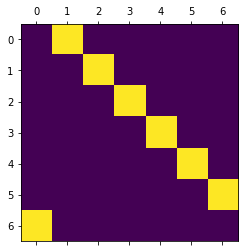

In [23]:
def plot_numbers(ax, next_nodes, sort_indices):
    ax.matshow(next_nodes[sort_indices][:, sort_indices], cmap="viridis")
    ax.grid(False)
    
fig = plt.figure(1, figsize=(4, 4))
ax = fig.add_subplot()
plot_numbers(ax, target_graph["next_nodes"], sort_indices)

In [41]:
NUM_NODES_TRAIN = (100,150)
NUM_NODES_VAL = (250,300)

class SampleGenerator(keras.utils.Sequence):

    def __init__(self, num_minmax, epoch_len):
        self.num_minmax = num_minmax
        self.epoch_len = epoch_len

    def __len__(self):
        return self.epoch_len #number of gradient descent steps per epoch

    def __getitem__(self, _index):
        inp, tar, _ = make_example(self.num_minmax)
        return inp, tar
    

train_gen = SampleGenerator(NUM_NODES_TRAIN, 1000)
val_gen = SampleGenerator(NUM_NODES_VAL, 50)

Define a model. We only have node inputs which are the numbers to sort. For each node, we want to predict the probability of being the "start" node (i.e. the node with the smallest number). For each edge we want to predict successor in a sorted linked list. We use a very simple GNN with only node states. Edge predictions are done on pairs of node states. 

We don't use global attributes for in- and output.

In [42]:
#a feedforward layer
def make_ff_layer(config):
    return keras.Sequential([
            layers.Dense(config["latent_dim"], activation="relu"),
            layers.Dense(config["latent_dim"]),
            layers.LayerNormalization()])

def make_GNN(config):
    
    #define the inputs
    #note: keras inputs have their batch size omitted in "shape"
    V = keras.Input(shape=(1), name="nodes") 
    
    n = tf.shape(V)[0]
    
    #step 1: encode
    #transform each node (dim=3) and edge (dim=1) to a latent embedding of "latent_dim"
    node_encoder = make_ff_layer(config)
    V_enc = node_encoder(V)
    
    #step 2: message passing
    node_messager = make_ff_layer(config)
    node_updater = make_ff_layer(config)
    for _ in range(config["message_passing_iterations"]):
        
        #the graph is fully connected, i.e. each node sends 
        #to all other nodes except itself 
        V_message = node_messager(V_enc)
        V_message = (tf.reduce_sum(V_message, axis=0, keepdims=True) - V_message) 
        V_message /= tf.cast(n-1, dtype=V_message.dtype)
        
        #update all nodes based on current state and aggregated edge states
        V_concat = tf.concat([V_enc, V_message], axis=-1)
        V_enc = node_updater(V_concat)
        
    #step 3: decode
    
    #layers
    node_decoder = layers.Dense(1)
    edge_decoder = keras.Sequential([
            layers.Dense(config["latent_dim"], activation="relu"),
            layers.Dense(1)])
    
    #in this case, we need node and edge predictions
    #for nodes, use the refined embeddings from message passing above:
    start_node_probs = node_decoder(V_enc)
    #remove "1" dimensions
    start_node_probs = tf.squeeze(start_node_probs)
    #decide for one start node
    start_node_probs = tf.nn.softmax(start_node_probs) 
    
    #for edges, use the respective pair of node embeddings (we did not use explicit edge embeddings)
    #organize edges as follows:
    #<n edges from v_1>, <n edges from v_2>, ..., <n edges from v_n>
    #we do not exclude self loops for simplicity
    V_tile = tf.tile(V_enc, [n,1]) #abc -> (abc abc ... abc) 
    V_rep = tf.repeat(V_enc, tf.ones(n,dtype=tf.int32)*n, axis=0) #abc -> (aa..a  bb..b  cc..c) 
    next_node_probs = edge_decoder(tf.concat([V_tile, V_rep], axis=-1))
    next_node_probs = tf.reshape(next_node_probs, (n,n))
    #for each node, decide for one "next" node
    #for conveniece, we define "start" to follow "end" to have a cycle
    next_node_probs = tf.nn.softmax(next_node_probs)
    
    model = keras.Model(inputs=[V], 
                        outputs=[layers.Lambda(lambda x: x, name="start_node")(start_node_probs),
                                layers.Lambda(lambda x: x, name="next_nodes")(next_node_probs)])

    return model    

In [44]:
config = {
    "message_passing_iterations" : 10,
    "latent_dim" : 16
}

NUM_EPOCHS = 20


GNN = make_GNN(config)

optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-3)

GNN.compile(loss={"start_node" : "categorical_crossentropy",
                  "next_nodes" : "categorical_crossentropy"}, 
            optimizer=optimizer, 
            metrics={"start_node" : "categorical_accuracy",
                     "next_nodes" : "categorical_accuracy"})

#takes ~2min on GPU
#note that this is unneccessarily long since we don't use batching
#to keep the code simple
history = GNN.fit(train_gen,
                    validation_data=val_gen,
                    epochs = NUM_EPOCHS,
                    verbose = 1)

Epoch 1/20
1000/1000 [==============================] - 7s 7ms/step - loss: 5.2243 - start_node_loss: 1.1372 - next_nodes_loss: 4.0870 - start_node_categorical_accuracy: 0.8270 - next_nodes_categorical_accuracy: 0.1359 - val_loss: 4.5623 - val_start_node_loss: 1.3491 - val_next_nodes_loss: 3.2131 - val_start_node_categorical_accuracy: 0.3800 - val_next_nodes_categorical_accuracy: 0.2658
Epoch 2/20
1000/1000 [==============================] - 7s 7ms/step - loss: 2.5028 - start_node_loss: 0.3650 - next_nodes_loss: 2.1378 - start_node_categorical_accuracy: 0.9800 - next_nodes_categorical_accuracy: 0.4389 - val_loss: 2.9392 - val_start_node_loss: 0.4544 - val_next_nodes_loss: 2.4848 - val_start_node_categorical_accuracy: 1.0000 - val_next_nodes_categorical_accuracy: 0.2946
Epoch 3/20
1000/1000 [==============================] - 7s 7ms/step - loss: 1.9618 - start_node_loss: 0.2408 - next_nodes_loss: 1.7210 - start_node_categorical_accuracy: 0.9940 - next_nodes_categorical_accuracy: 0.4693 -

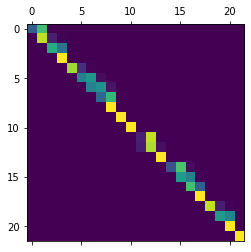

In [49]:
input_graph, _, sort_indices = make_example((20,30))
fig = plt.figure(1, figsize=(4, 4))
ax = fig.add_subplot()
start_node_probs, next_node_probs = GNN(input_graph)
plot_numbers(ax, next_node_probs.numpy(), sort_indices)

### Decode a sorted list

Start at the predicted start node. Greedily follow to the next unvisited node with highest probabilty.

In [57]:
def decode_sorting(numbers, start_node_probs, next_node_probs):
    print("unsorted numbers:", numbers)
    start = np.argmax(start_node_probs)
    sort_indices = [start]
    unvisited = np.ones(len(numbers))
    unvisited[start] = 0
    current_node = start
    for i in range(len(numbers)-1):
        probs = unvisited * next_node_probs[current_node]
        current_node = np.argmax(probs)
        unvisited[current_node] = 0
        sort_indices.append(current_node)
    print("sorted numbers:", numbers[sort_indices])

decode_sorting(input_graph["nodes"], start_node_probs, next_node_probs)

unsorted numbers: [0.77582657 0.0762433  0.36435593 0.9758827  0.25454118 0.31118793
 0.64610911 0.2750251  0.74613055 0.51478395 0.84502217 0.28713276
 0.72261328 0.30016552 0.88454247 0.70968779 0.13840706 0.09063094
 0.9038374  0.60916656 0.16198563 0.61216323]
sorted numbers: [0.0762433  0.09063094 0.13840706 0.16198563 0.25454118 0.2750251
 0.28713276 0.30016552 0.31118793 0.36435593 0.51478395 0.60916656
 0.61216323 0.64610911 0.70968779 0.72261328 0.74613055 0.77582657
 0.84502217 0.88454247 0.9038374  0.9758827 ]
